In [1]:
import pylab as plt
import numpy as np
import pandas as pd
import proposal as pp  #installed with pip
import scipy
from scipy import interpolate
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import re
import sys
import glob
from MCEq.core import config, MCEqRun
import crflux.models as crf
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import random
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [2]:
def get_color(n, colormax, cmap="PiYG"):
    
    this_cmap = plt.get_cmap(cmap)
    return this_cmap(n/colormax)


'\n# continuously interpolate rock length and depth functions so we can sample at any X,Y\nrocklength=scipy.interpolate.interp2d(x,y,distancetodetector)\ndepth     =scipy.interpolate.interp2d(x,y,z)\n\n# a handy function to go from surface position to angles, depth, distance\ndef GetMuonInfo(startMuon):\n    depthMuon   = np.round(depth(*startMuon)[0],2)\n    distMuon    = np.round(rocklength(*startMuon)[0],2)\n    thMuon      = np.round(np.arctan((startMuon[0]**2+startMuon[1]**2)**0.5/depthMuon),2)\n    phiMuon     = np.round(np.arctan(startMuon[1]/startMuon[0]),2)\n    return thMuon,phiMuon,depthMuon,distMuon'

In [616]:
CLRS=["gray","firebrick","orchid","deepskyblue","orange","blueviolet","magenta","limegreen","pink","tomato","red","black","yellow","darkgreen"]

energies=[100,250,500,1000,5000,10000,15000,20000,25000,750,2000,3000,4000,7500,12500,1500,6000,8500,11000]
GeV=1000

In [13]:
#mountain profile
'''pdmtn=pd.read_hdf('/Users/rogerslc/Documents/MuFluxPred/MountainProfile.h5')

Ymax=int(np.round(pdmtn['Y'].max(),0))
Xmax=int(np.round(pdmtn['X'].max(),0))
Ymin=int(np.round(pdmtn['Y'].min(),0))
Xmin=int(np.round(pdmtn['X'].min(),0))

Del=100

vals=[]
X1= range(Xmin,Xmax, Del)
Y1= range(Ymin,Ymax, Del)
for ys in Y1:
    for xs in X1:   
        pts=pdmtn[(pdmtn.X>=xs) &(pdmtn.X<=xs+Del)&(pdmtn.Y>=ys) &(pdmtn.Y<=ys+Del)].Z.unique()
        ptsz=np.mean(pts)       
        vals.append(ptsz)

vals = np.array(vals)
where_are_NaNs = np.isnan(vals)
vals[where_are_NaNs] = 200
zz=vals.reshape(len(Y1), len(X1))
[xx,yy]=np.meshgrid(np.arange(Xmin,Xmax,Del),np.arange(Ymin,Ymax,Del))

#Find the thetas and phis and distance through rock for each grid square
phioffset=np.pi/3                      # Orientation of detector relative to map - you need to figure this out.
rhod=(xx**2+yy**2)**0.5             # cylindrical rho coordinate
thetad=np.arctan(rhod/zz)           # spherical theta coordinate (0 = downgoing)
phid = np.arctan(yy/xx) + phioffset # spherical phi coordinate
distancetodetectord = np.sqrt(zz**2+xx**2+yy**2)


# continuously interpolate rock length and depth functions so we can sample at any X,Y
rocklength=scipy.interpolate.interp2d(x,y,distancetodetector)
depth     =scipy.interpolate.interp2d(x,y,z)

# a handy function to go from surface position to angles, depth, distance
def GetMuonInfo(startMuon):
    depthMuon   = np.round(depth(*startMuon)[0],2)
    distMuon    = np.round(rocklength(*startMuon)[0],2)
    thMuon      = np.round(np.arctan((startMuon[0]**2+startMuon[1]**2)**0.5/depthMuon),2)
    phiMuon     = np.round(np.arctan(startMuon[1]/startMuon[0]),2)
    return thMuon,phiMuon,depthMuon,distMuon'''

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/jm/hwfgsj_5419b1s2h09k6lflr6k3jsz/T/ipykernel_7449/3179013696.py:28: RuntimeWarning: divide by zero encountered in true_divide
  thetad=np.arctan(rhod/zz)           # spherical theta coordinate (0 = downgoing)


In [4]:
#MCeQ outputs
r=0

for files in glob.glob('/Users/rogerslc/Documents/MuFluxPred/Muons*degrees.h5'):
    #print (files,re.search('Muons(.*)degrees', files))
    run=re.search('Muons(.*)degrees', files)
    ths=int(run.group(1))
    if r==0:
        musData=pd.read_hdf(files)
        musData['theta']=    ths
        r+=1
    else:
        df=pd.read_hdf(files)
        df['theta']=ths
        musData=musData.append(df, ignore_index=True)
        
musData['altitude']=musData.altitude*10**-2    
k=musData.theta.unique()
k.sort()
print(k)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


In [264]:
#saving interpolations for all thetas
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum
'''
k=musData.theta.unique()
k.sort()

nrgs=np.geomspace(np.min(energies)*10**-3,np.max(energies)*10**-3,20)
    
# The lines below are for plotting with matplotlib
for theta in range(0,90,5):
    print(theta)
    df=musData[(musData.theta==theta)&(musData.MuFLux>10**-9)]
    Es=df.Energies
    Es=Es.unique()
    Es.sort()
    As=df.altitude.unique()
    As.sort()
    flxs=[]   
    x=df.Energies
    y=df.MuFLux


    for nrg in Es:
        for alt in As:
            flxs.append(df[(df.Energies==nrg)&(df.altitude==alt)].MuFLux.iloc[0])
            if len(df[(df.Energies==nrg)&(df.altitude==alt)].MuFLux) == 0:
                print( nrg, alt)
                


    flxarray=np.array(flxs)
    flxarray = flxarray.reshape(len(Es), len(As))
    FluxMuons=scipy.interpolate.RectBivariateSpline(Es,As,flxarray,s=0,kx=3, ky=3)

    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'wb') as f:
        pickle.dump(FluxMuons, f)
'''

0
1820.5 1043.0
5
1820.5 1043.0
10
1820.5 1043.0
15
1820.5 1043.0
20
1820.5 1043.0
25
1820.5 1043.0
30
1820.5 1043.0
35
1820.5 1043.0
40
1820.5 1043.0
45
1820.5 1043.0
50
1820.5 1043.0
55
1820.5 1043.0
60
1820.5 1043.0
65
1820.5 1043.0
70
1820.5 1043.0
75
1820.5 1043.0
80
1820.5 1043.0
85
1820.5 1043.0


In [274]:
#saving interpolations for all thetas and energies
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum
'''
k=musData.theta.unique()
k.sort()

alt=1431   
flxs=[] 
for theta in k:
    df=musData[(musData.theta==theta)&(musData.MuFLux>10**-9)]
    Es=df.Energies
    Es=Es.unique()
    Es.sort()
  


    for nrg in Es:
        flxs.append(df[(df.Energies==nrg)&(df.altitude==alt)].MuFLux.iloc[0])
        if len(df[(df.Energies==nrg)&(df.altitude==alt)].MuFLux) == 0:
            print( nrg, alt)
                


flxarray=np.array(flxs)
flxarray = flxarray.reshape(len(k), len(Es))
FluxMuons=scipy.interpolate.RectBivariateSpline(k,Es,flxarray,s=0,kx=3, ky=3)

with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_ALL.pkl', 'wb') as f:
    pickle.dump(FluxMuons, f)'''

In [623]:
r=0

for files in glob.glob('/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons*5.h5'):
    #print (files)
    run=re.search('Muons(.*)_', files)
    X=str(run.group(1))
    run=re.search('_(.*).h5', files)
    Y=str(run.group(1))
    if r==0:
        musDatamtn=pd.read_hdf(files)
        musDatamtn['X']=    X
        musDatamtn['Y']=    Y        
        r+=1
    else:
        df=pd.read_hdf(files)
        df['X']=    X
        df['Y']=    Y  
        musDatamtn=musDatamtn.append(df, ignore_index=True)
        
for files in glob.glob('/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons*ADDITIONAL.h5'):
    #print (files)
    run=re.search('Muons(.*)_', files)
    X=str(run.group(1))

    run=re.search('_(.*)ADDITIONAL.h5', files)
    Y=str(run.group(1))

    df=pd.read_hdf(files)
    df['X']=    X
    df['Y']=    Y  
    musDatamtn=musDatamtn.append(df, ignore_index=True)        
    
for files in glob.glob('/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons*ADDITIONAL_R2.h5'):
    #print (files)
    run=re.search('Muons(.*)_*ADDITIONAL_R2.h5', files)
    X=str(run.group(1))
    run2=re.search('(.*)_', X)
    X=str(run2.group(1))
    run=re.search('_(.*)ADDITIONAL_R2.h5', files)
    Y=str(run.group(1))

    df=pd.read_hdf(files)
    df['X']=    X
    df['Y']=    Y  
    musDatamtn=musDatamtn.append(df, ignore_index=True)   
        
musDatamtn['X'] = musDatamtn['X'].astype(float)        
musDatamtn['Y'] = musDatamtn['Y'].astype(float)          

#musDatamtn=musDatamtn[musDatamtn.theta>=0]
kX=musDatamtn.X.unique()
kX.sort()
lY=musDatamtn.Y.unique()
lY.sort()
print(kX,lY)

musDatamtn['ThinDeg']=musDatamtn['X']
musDatamtn['NRG']=musDatamtn['X']
for X in kX:
    for Y in lY:
        Ts=musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].Theta.iloc[8][0]
        for L in range (0,len(energies)):
            musDatamtn.iloc[musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].index[L], musDatamtn.columns.get_loc('ThinDeg')] = np.rad2deg(Ts)
            musDatamtn.iloc[musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].index[L], musDatamtn.columns.get_loc('NRG')] = energies[L]
            
musDatamtn['ThinDeg']=np.where(musDatamtn['ThinDeg'] <0,musDatamtn['ThinDeg']+180,musDatamtn['ThinDeg'])

musDatamtn = musDatamtn.sort_values(["ThinDeg", "NRG"], ascending = (True, True))

/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-405_-2255ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons495_-1655ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons795_145ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons395_645ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons795_-1055ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-105_645ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-5_-855ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-505_145ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-105_-155ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons795_-55ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1195_-655ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-305_-1155ADDITIONAL_R2.h5


/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-205_-455ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1095_-2255ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1295_-355ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-505_-155ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons495_-755ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-405_-1755ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1395_-555ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-305_645ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons595_145ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons195_645ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons595_-155ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-405_-755ADDITIONAL_R2.

/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons495_-2055ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1395_-655ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-305_545ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-505_45ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons395_-1355ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-305_-155ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons295_-755ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_-755ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1495_-355ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons695_-1955ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons695_-655ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1495_-2055ADDITIONAL_R2.h

/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1095_-355ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons995_145ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_-1855ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons195_-255ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons895_-1355ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons995_-55ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1095_-1455ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1395_-1255ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons995_-555ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-305_-1755ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons795_-455ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-105_-755ADDITIONAL_R2.

/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-5_345ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-505_-1755ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons695_-55ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons795_-855ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-405_-55ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons995_-955ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_-1155ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1095_345ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_45ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1195_-2255ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1495_445ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons895_245ADDITIONAL_R2.h5
/Users/

/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons895_-855ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons695_-955ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_545ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons995_-2255ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1095_445ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_-1655ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1495_345ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons895_545ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons295_-855ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_-855ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons695_-1655ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons595_-1055ADDITIONAL_R2.h5
/User

/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons295_545ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons695_245ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons795_-1955ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-305_-1855ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons-505_-1455ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons595_-2055ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_145ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons95_-1255ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1195_-2155ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1095_-955ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons1495_745ADDITIONAL_R2.h5
/Users/rogerslc/PROPOSAL/PROPOSAL/coordfinal/ProposalMuons895_145ADDITIONAL_R2.h5


In [247]:
#save interpolatations for proposal output for all X,Y for each energy
'''for LOC in range(0,len(energies)):
    r=0
    Xs=[]
    Ys=[]
    Percs=[]

    NRG=energies[LOC]*GeV



    for X in kX:
        for Y in lY:
            percsum=0
            multi=0
            if len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)])==0:
                Xs.append(X)
                print("missing",X,Y)
                Percs.append(0) #need to rerun anything missing
                Ys.append(Y)
                continue
            if len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].FinalMuons.iloc[LOC]) <=0:
                perc=0
            else:
                perc=len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].FinalMuons.iloc[LOC])/NumToRun
            Xs.append(X)
            Percs.append(perc)
            Ys.append(Y)


    df=pd.DataFrame(Xs, columns = ['X'])
    df['Y']=Ys
    df['perc']=Percs

    percsarray=np.array(df.perc)
    percsarray = percsarray.reshape(len(df.X.unique()), len(df.Y.unique()))
    PercentMuons=scipy.interpolate.RectBivariateSpline(np.unique(df.X),np.unique(df.Y),percsarray,s=0,kx=3, ky=3)

    with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator'+str(NRG)+'TeV.pkl', 'wb') as f:
        pickle.dump(PercentMuons, f)'''

In [738]:
#save interpolatations for proposal output for all energies and theta
TK=musDatamtn.ThinDeg.unique()
L=np.sort(energies)
nrgs=[]
Percs=[]
Thets=[]



for LOC in range(0,len(L)):
    NRG=L[LOC]
    for thees in TK:

        if len(musDatamtn[(musDatamtn.ThinDeg==thees)&(musDatamtn.NRG==NRG)].FinalMuons.iloc[0]) ==0:
            perc=0
        else:
            perc=len(musDatamtn[(musDatamtn.ThinDeg==thees)&(musDatamtn.NRG==NRG)].FinalMuons.iloc[0])/NumToRun
        Percs.append(perc)
        Thets.append(musDatamtn[(musDatamtn.ThinDeg==thees)&(musDatamtn.NRG==NRG)].ThinDeg.iloc[0])
        nrgs.append(NRG)


df=pd.DataFrame(Thets, columns = ['theta'])
df['perc']=Percs
df['energy']=nrgs

percsarray=np.array(df.perc)
percsarray = percsarray.reshape(len(energies), len(TK))
PercentMuons=scipy.interpolate.interp2d(L,TK, np.transpose(percsarray), kind='linear')

with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'wb') as f:
    pickle.dump(PercentMuons, f)

In [748]:
#save interpolatations for proposal output for all energies and theta
TK=musDatamtn.ThinDeg.unique()
L=np.sort(energies)
nrgs=[]
Percs=[]
Thets=[]
L=np.append(L,10**5)


for LOC in range(0,len(L)):
    NRG=L[LOC]
    for thees in TK:
        if NRG==10**5:
            Percs.append(1)
            Thets.append(thees)
            nrgs.append(NRG)
            continue
        if len(musDatamtn[(musDatamtn.ThinDeg==thees)&(musDatamtn.NRG==NRG)].FinalMuons.iloc[0]) ==0:
            perc=0
        else:
            perc=len(musDatamtn[(musDatamtn.ThinDeg==thees)&(musDatamtn.NRG==NRG)].FinalMuons.iloc[0])/NumToRun
        Percs.append(perc)
        Thets.append(musDatamtn[(musDatamtn.ThinDeg==thees)&(musDatamtn.NRG==NRG)].ThinDeg.iloc[0])
        nrgs.append(NRG)


df=pd.DataFrame(Thets, columns = ['theta'])
df['perc']=Percs
df['energy']=nrgs

percsarray=np.array(df.perc)
percsarray = percsarray.reshape(len(L), len(TK))
PercentMuons=scipy.interpolate.interp2d(L,TK, np.transpose(percsarray), kind='linear')

with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'wb') as f:
    pickle.dump(PercentMuons, f)

In [743]:
musDatamtn[(musDatamtn.ThinDeg==thees)&(musDatamtn.NRG==NRG)].FinalMuons

Series([], Name: FinalMuons, dtype: object)

In [745]:
NRG

100000

In [746]:
L

array([   100,    250,    500,    750,   1000,   1500,   2000,   3000,
         4000,   5000,   6000,   7500,   8500,  10000,  11000,  12500,
        15000,  20000,  25000, 100000])

In [ ]:
#save interpolatations for proposal output for all energies over all the X and Y
'''for LOC in range(0,len(energies)):
    r=0
    Xs=[]
    Ys=[]
    Percs=[]

    NRG=energies[LOC]*GeV



    for X in kX:
        for Y in lY:
            percsum=0
            multi=0
            if len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)])==0:
                Xs.append(X)
                print("missing",X,Y)
                Percs.append(0) #need to rerun anything missing
                Ys.append(Y)
                continue
            if len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].FinalMuons.iloc[LOC]) <=0:
                perc=0
            else:
                perc=len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].FinalMuons.iloc[LOC])/NumToRun
            Xs.append(X)
            Percs.append(perc)
            Ys.append(Y)


    df=pd.DataFrame(Xs, columns = ['X'])
    df['Y']=Ys
    df['perc']=Percs

    percsarray=np.array(df.perc)
    percsarray = percsarray.reshape(len(df.X.unique()), len(df.Y.unique()))
    PercentMuons=scipy.interpolate.RectBivariateSpline(np.unique(df.X),np.unique(df.Y),percsarray,s=0,kx=3, ky=3)

    with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator'+str(NRG)+'TeV.pkl', 'wb') as f:
        pickle.dump(PercentMuons, f)'''

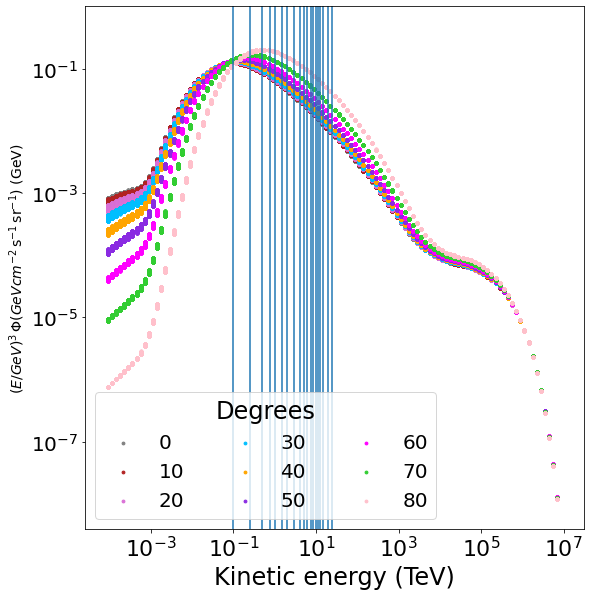

In [626]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=musData.theta.unique()
k.sort()

clr=0

# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,10):
    x=musData[(musData.theta==theta)&(musData.MuFLux>10**-9)].Energies*GeV/10**6
    y=musData[(musData.theta==theta)&(musData.MuFLux>10**-9)].MuFLux

    
    plt.scatter(x, y, label=str(theta),s=8,color=CLRS[clr])

    clr+=1
    
for E in energies:
    plt.vlines(E*10**-3,4e-9, 1)

plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(1., 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
plt.ylim(4e-9, 1.)
plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=14)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=3,loc='lower left')
plt.show()

100.0
133.72338725601037
178.81944299220916
239.12341624151261
319.7639319204395
427.59916098701467
571.800081950117
764.6304379163397
1022.4897215721949
1367.307890030888
1828.410424767989
2445.012352941762
3269.5533371816055
4372.157470621169
5846.597065881333
7818.267635707035
10454.852307207844
13980.58263781148
18695.308661407194
25000.0
100.0
133.72338725601037
178.81944299220916
239.12341624151261
319.7639319204395
427.59916098701467
571.800081950117
764.6304379163397
1022.4897215721949
1367.307890030888
1828.410424767989
2445.012352941762
3269.5533371816055
4372.157470621169
5846.597065881333
7818.267635707035
10454.852307207844
13980.58263781148
18695.308661407194
25000.0
100.0
133.72338725601037
178.81944299220916
239.12341624151261
319.7639319204395
427.59916098701467
571.800081950117
764.6304379163397
1022.4897215721949
1367.307890030888
1828.410424767989
2445.012352941762
3269.5533371816055
4372.157470621169
5846.597065881333
7818.267635707035
10454.852307207844
13980.5826

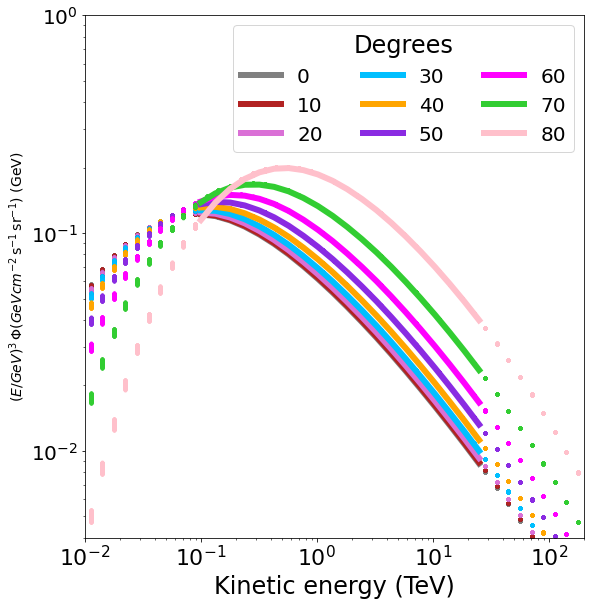

In [712]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=musData.theta.unique()
k.sort()

clr=0
nrgs=np.geomspace(np.min(energies)*10**-3,np.max(energies)*10**-3,20)
    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,10):
    #MCeq data
    df=musData[(musData.theta==theta)&(musData.MuFLux>10**-9)]  
    x=df.Energies
    y=df.MuFLux
    

    
    #bring in the intorpolation funcs
    flxs=[]
    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'rb') as f:
        FluxMuons = pickle.load(f)
    
    for NG in nrgs:
        flxs.append(FluxMuons(NG/(GeV/10**6),650)[0][0])

    plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])        
    plt.plot(nrgs,flxs,linewidth=6,color=CLRS[clr], label=str(theta))
    clr+=1
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.01, 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-9, 1.)
plt.ylim(4e-3, 1.)

plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=14)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=3,loc='upper right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()

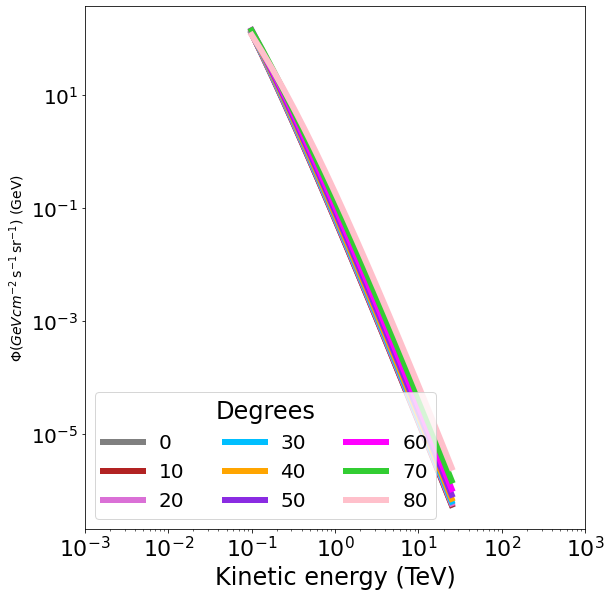

In [628]:
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=musData.theta.unique()
k.sort()

clr=0
nrgs=np.geomspace(np.min(energies)*10**-3,np.max(energies)*10**-3,20)
    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,10):
    flxs=[]
    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'rb') as f:
        FluxMuons = pickle.load(f)
    
    for NG in nrgs:
        flxs.append(FluxMuons(NG/(GeV/10**6),650)[0][0]/NG**3)
        
    plt.plot(nrgs,flxs,linewidth=6,color=CLRS[clr], label=str(theta))
    clr+=1
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(1., 2e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-4, 1.)
plt.xlim(1e-3, 1e3)
plt.ylabel(r'$\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=14)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=3,loc='lower left')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()

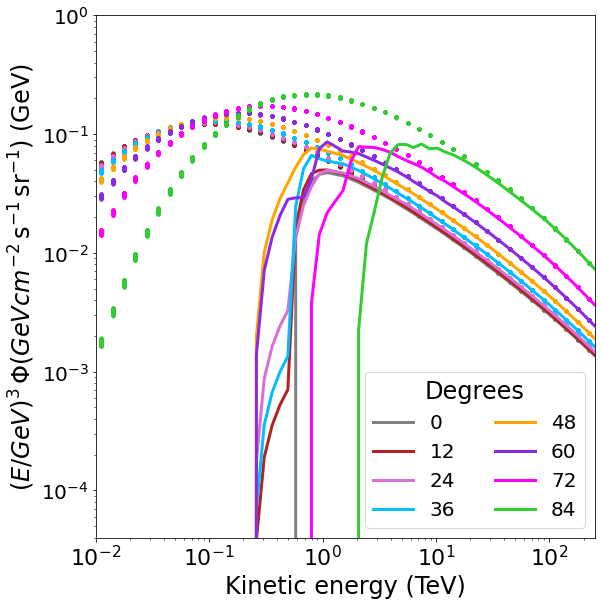

In [759]:
#need to multiply flux by percent
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=musData.theta.unique()
k.sort()

#bring in the intorpolation funcs
with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator_ALL.pkl', 'rb') as f:
    FluxMuons = pickle.load(f) #use as FluxMuons(theta,energy)

with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
nrgs=np.geomspace(np.min(energies),2.5e5,50)


    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,12):
    flxs=[]     
    flxs2=[]
    with open('/Users/rogerslc/Documents/MuFluxPred/MCeQ_Muons_interpolator'+str(theta)+'.pkl', 'rb') as f:
        FluxMuons = pickle.load(f)
    for NG in nrgs:            
        flxs.append(FluxMuons(NG,650)[0][0]*PercentMuons(NG,theta)[0])   
        flxs2.append(FluxMuons(NG,650)[0][0])
        #print(NG,FluxMuons(NG,650)[0][0])

    #plt.plot(nrgs*GeV/10**6,flxs2,linewidth=6,color=CLRS[clr], label='_nolegend_')    
        

      
    plt.plot(nrgs*GeV/10**6,flxs,linewidth=3,color=CLRS[clr], label=str(theta))

    
    #MCeq data
    df=musData[(musData.theta==theta)&(musData.MuFLux>10**-9)&(musData.Energies>4)]  
    x=df.Energies
    y=df.MuFLux
    
    plt.scatter(x*GeV/10**6, y, label='_nolegend_',alpha=.3,s=8,color=CLRS[clr])      
    clr+=1
    
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.01, 2.5e2)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(4e-8, 4e-3)
#plt.ylim(4e-3, 1.)
plt.ylim(4e-5, 1.)

plt.ylabel(r'$(E/ {GeV})^3\,\Phi (GeV cm^{-2}\,$s$^{-1}\,$sr$^{-1}$) (GeV)',fontsize=24)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=2,loc='lower right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()


In [754]:
np.max(energies)

25000

In [756]:
2e5

200000.0

In [695]:
nrgs

array([  100.        ,   111.92769269,   125.27808392,   140.22086878,
         156.9459831 ,   175.66601767,   196.61892042,   220.07102103,
         246.32041613,   275.70075841,   308.58549762,   345.39262748,
         386.58999868,   432.70126571,   484.31254296,   542.07985477,
         606.737474  ,   679.10725537,   760.10908185,   850.77255728,
         952.25009344,  1065.83155827,  1192.96067118,  1335.253354  ,
        1494.51827076,  1672.77981736,  1872.30385343,  2095.62650337,
        2345.58639272,  2625.36072952,  2938.50568946,  3289.00161791,
        3681.30362361,  4120.39820699,  4611.86664291,  5161.95592355,
        5777.65816314,  6466.79947377,  7238.13944217,  8101.48247163,
        9067.80240454, 10149.3820095 , 11359.96910598, 12714.95131112,
       14231.55162977, 15929.04737382, 17829.01519373, 19955.60533648,
       22335.84861634, 25000.        ])

In [701]:
25000000.0

25000000.0

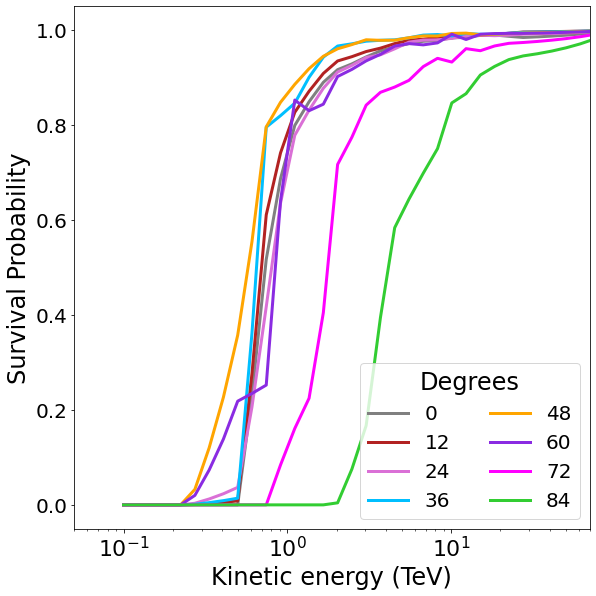

In [760]:
#need to multiply flux by percent
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

k=musData.theta.unique()
k.sort()

#bring in the intorpolation funcs
with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator_ALL.pkl', 'rb') as f:
    PercentMuons = pickle.load(f) #use as PercentMuons(energy,theta)

clr=0
nrgs=np.geomspace(np.min(energies),2.5e5,40)


    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,12):
    flxs=[]     
    for NG in nrgs:            
        flxs.append(PercentMuons(NG,theta)[0])   
    #print(FluxMuons(theta,NG/(GeV/10**6))[0][0],PercentMuons(NG/(GeV/10**6),theta)[0][0])      
    #plt.scatter(nrgs*(GeV/10**6), flxs, label=str(theta),alpha=1,s=14,color=CLRS[clr])        
    plt.plot(nrgs*(GeV/10**6),flxs,linewidth=3,color=CLRS[clr], label=str(theta))
    clr+=1
    
#plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.05, 7e1)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(-4e-3, 4e-3)
#plt.ylim(4e-3, 1.)

plt.ylabel(r'Survival Probability',fontsize=24)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=2,loc='lower right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()



In [519]:
PercentMuons(35000000,30)[0]

0.9911209795213609

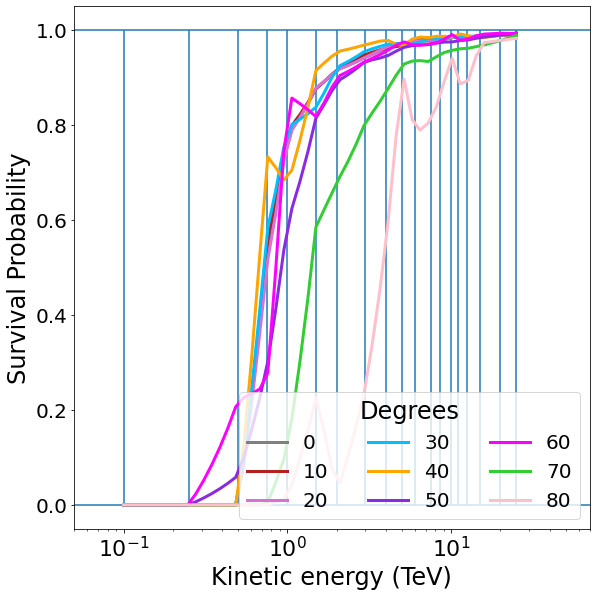

In [631]:
# need to multiply flux by percent
plt.figure(figsize=(8,8))
# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum

clr=0
nrgs=np.geomspace(np.min(energies),np.max(energies),50)

    
# The lines below are for plotting with matplotlib
#for theta in k:
for theta in range(0,90,10):
    flxs=[]     
    for NG in nrgs:            
        flxs.append(PercentMuons(NG,theta)[0])   
    #print(FluxMuons(theta,NG/(GeV/10**6))[0][0],PercentMuons(NG/(GeV/10**6),theta)[0][0])      
    #plt.scatter(nrgs*(GeV/10**6), flxs, label=str(theta),alpha=1,s=14,color=CLRS[clr])        
    plt.plot(nrgs*(GeV/10**6),flxs,linewidth=3,color=CLRS[clr], label=str(theta))
    clr+=1
    
#plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.xlim(.05, 7e1)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(-4e-3, 4e-3)
#plt.ylim(4e-3, 1.)

plt.hlines(0,10**-2,10**2)
plt.hlines(1,10**-2,10**2)

for E in energies:
    plt.vlines(E*10**-3,4e-9, 1)


plt.ylabel('Survival Probability',fontsize=24)
plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=3,loc='lower right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()





In [609]:
L [1500,6000,8500,11000]

array([  100,   250,   500,   750,  1000,  2000,  3000,  4000,  5000,
        7500, 10000, 12500, 15000, 20000, 25000])

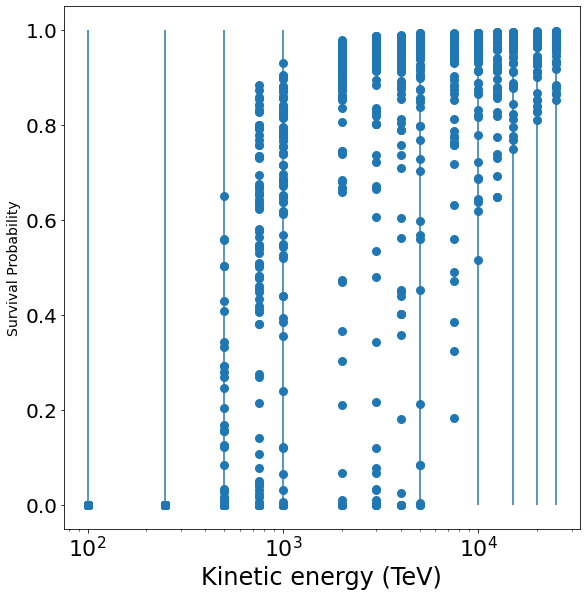

In [612]:
# survival pts ran
plt.figure(figsize=(8,8))

clr=0


plt.scatter(df.energy,df.perc,linewidth=3, label=str(theta))

    
#plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.xlim(.05, 7e1)
plt.xlabel('Kinetic energy (TeV)',fontsize=24)
#plt.ylim(-4e-3, 4e-3)

#plt.hlines(0,10**-2,10**2)
#plt.hlines(1,10**-2,10**2)

for E in [100,250,500,1000,5000,10000,15000,20000,25000]:
    plt.vlines(E,4e-9, 1)

plt.ylabel('Survival Probability',fontsize=14)
#plt.legend(fontsize=20,title='Degrees',title_fontsize=24,ncol=3,loc='lower right')
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/FluxesForSomeDeg.png",dpi=250,bbox_inches='tight')
plt.show()






###### 

In [642]:
df

,MuFLux,Energies,theta,columndepth,altitude
2279691,8.667428e-02,1.122018e+04,84,7132.675338,1820.5
2279692,7.556998e-02,1.412538e+04,84,7132.675338,1820.5
2279693,6.548402e-02,1.778279e+04,84,7132.675338,1820.5
2279694,5.637002e-02,2.238721e+04,84,7132.675338,1820.5
2279695,4.816745e-02,2.818383e+04,84,7132.675338,1820.5
...,...,...,...,...,...
2317619,2.728775e-07,3.548134e+09,84,7911.389462,1043.0
2317620,1.082988e-07,4.466836e+09,84,7911.389462,1043.0
2317621,3.759858e-08,5.623413e+09,84,7911.389462,1043.0
2317622,1.105722e-08,7.079458e+09,84,7911.389462,1043.0


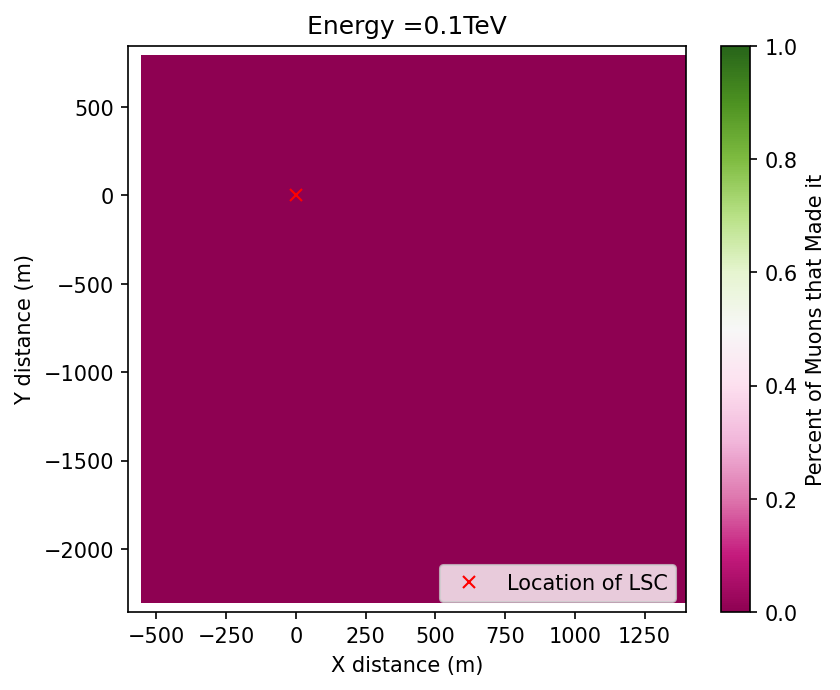

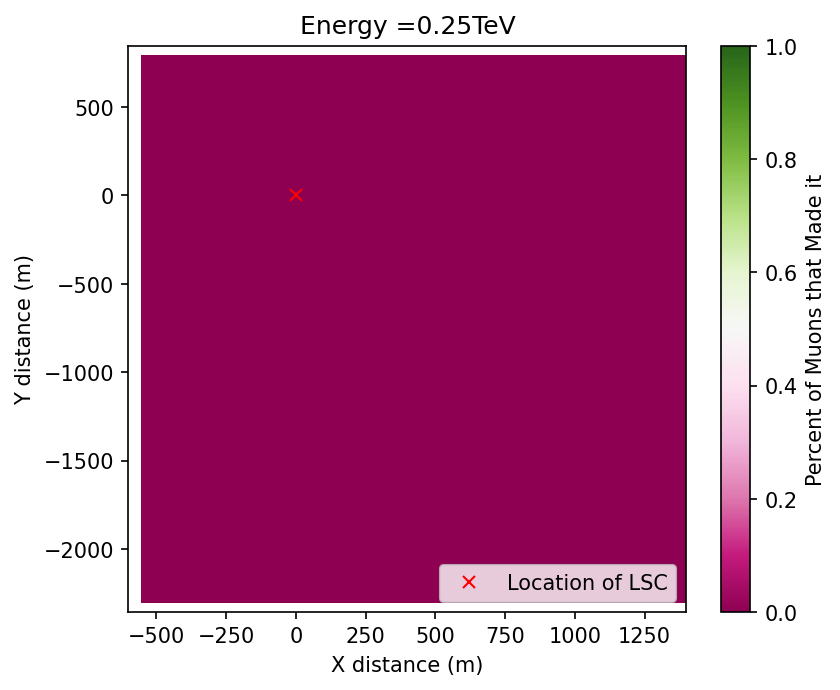

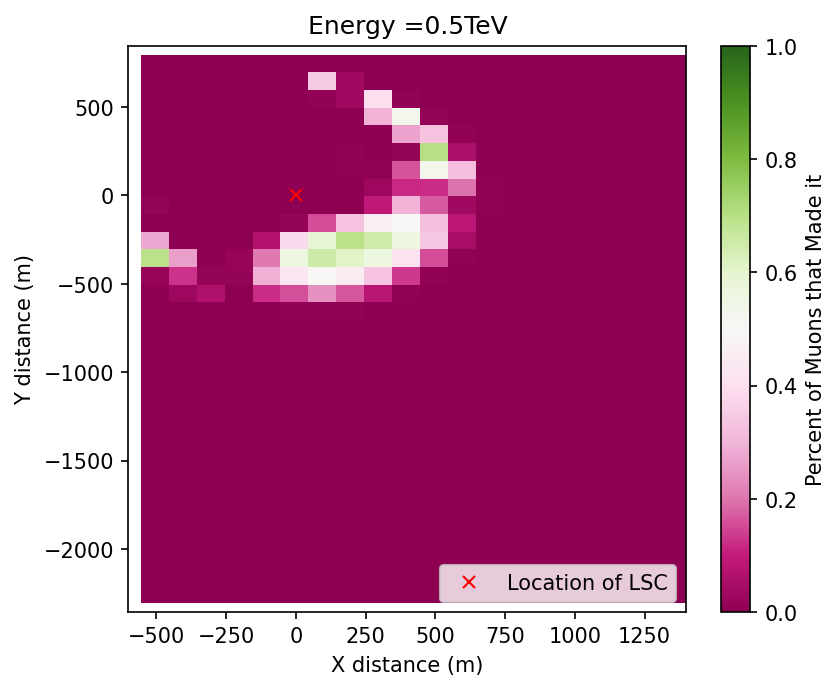

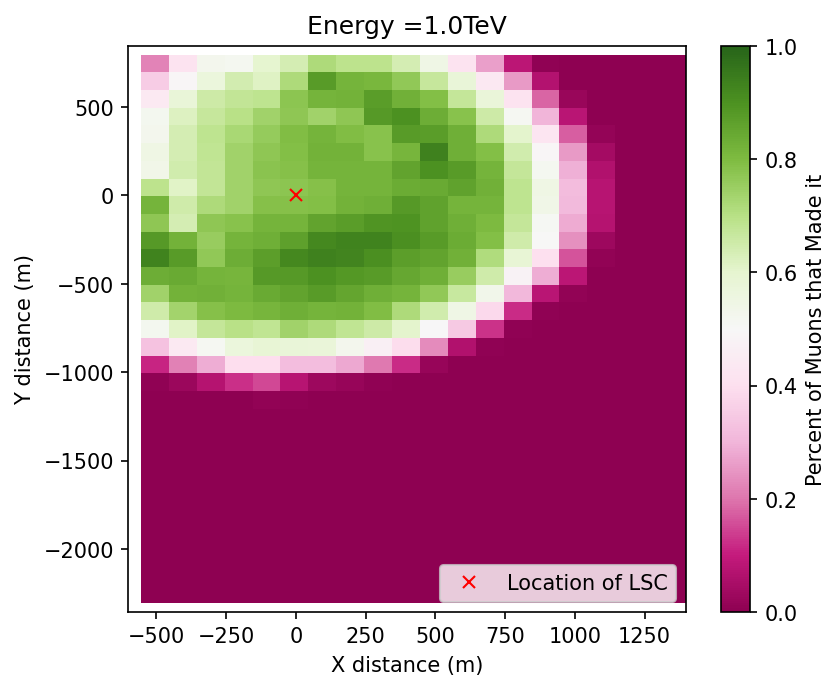

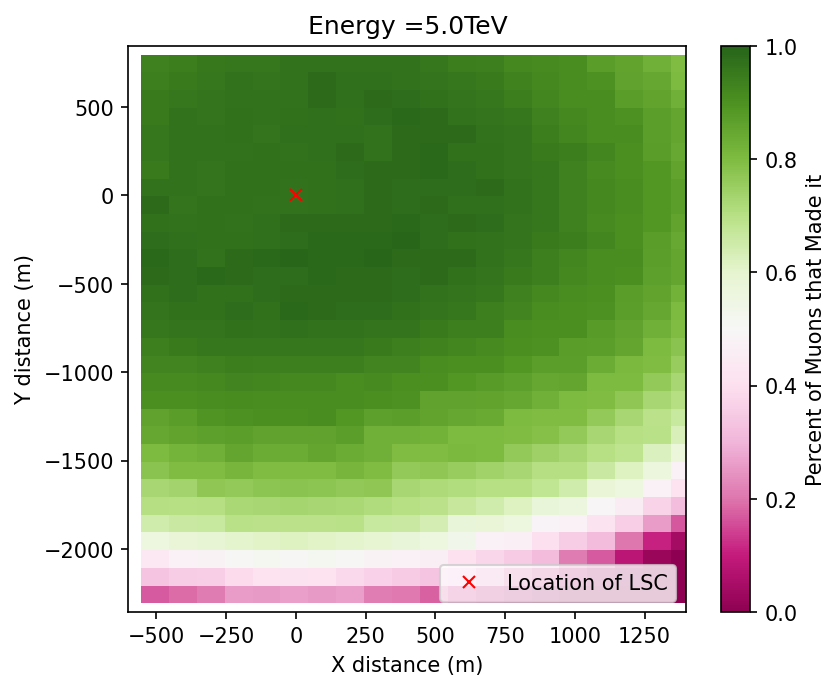

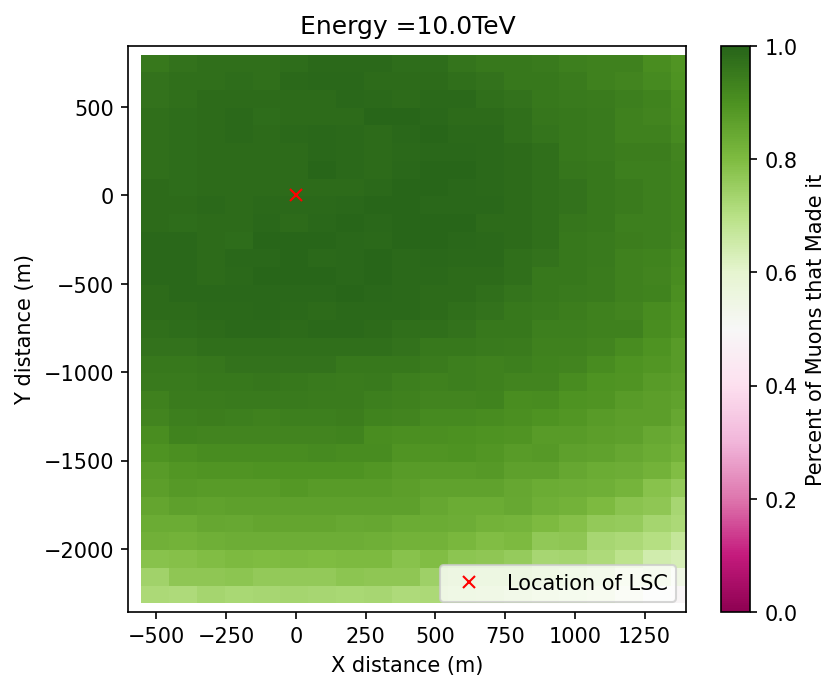

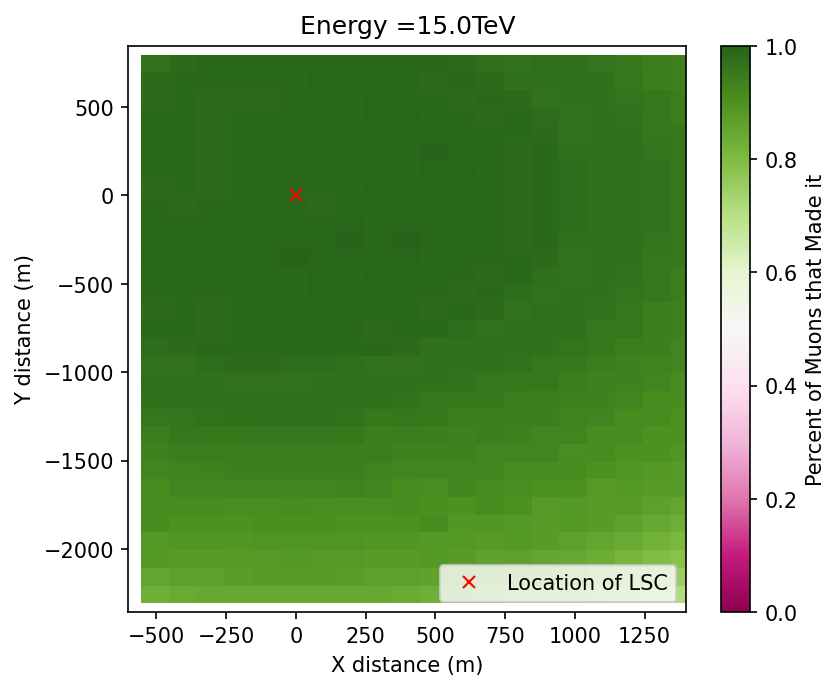

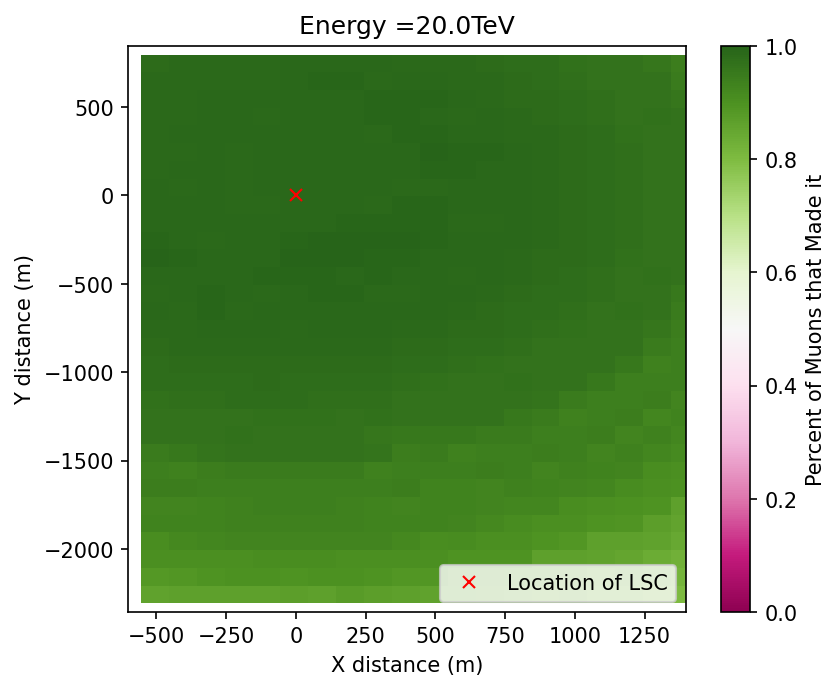

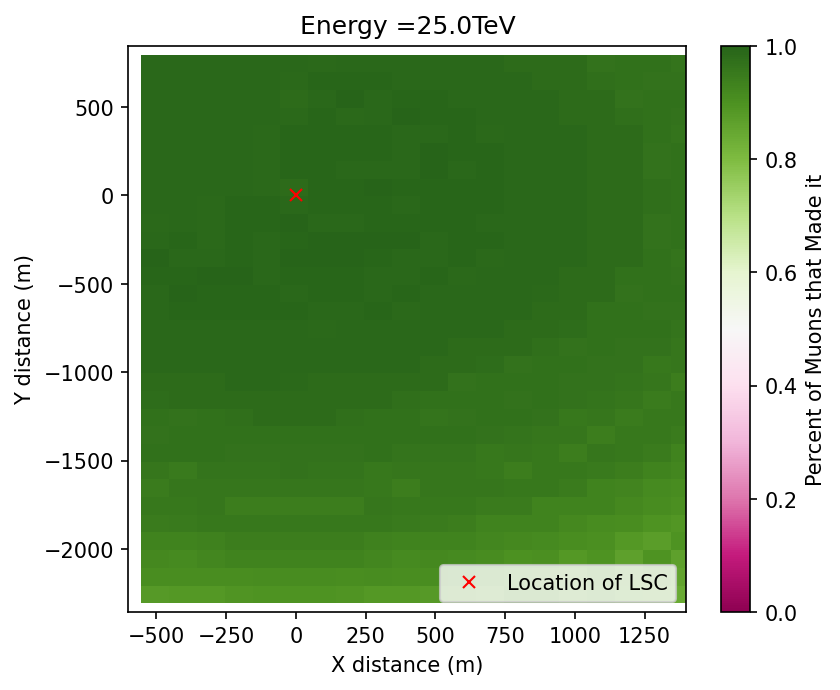

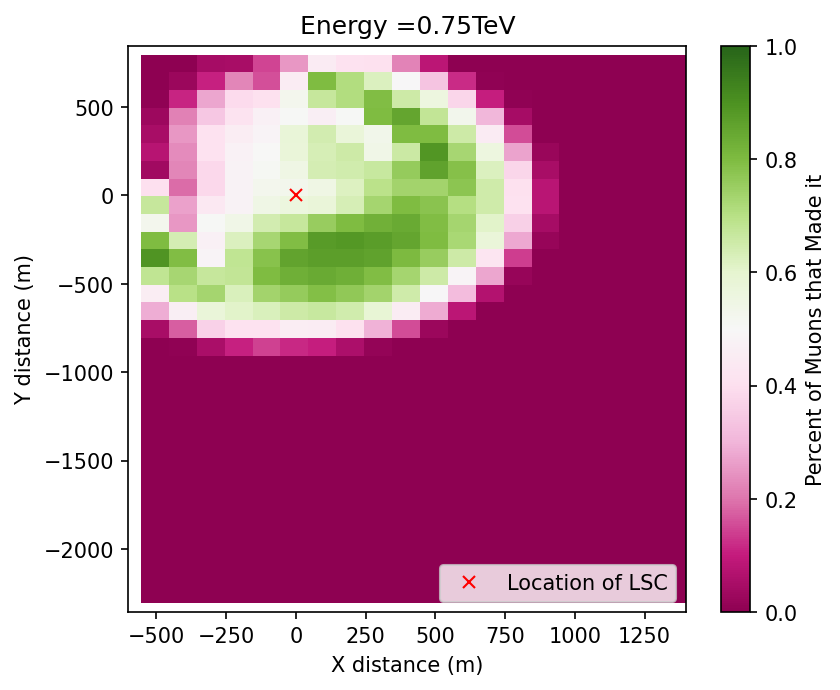

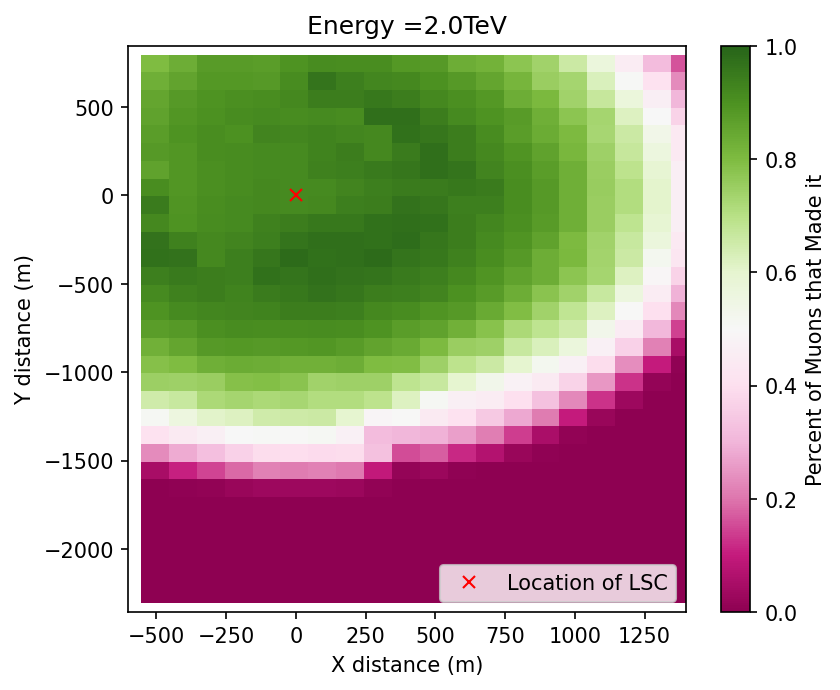

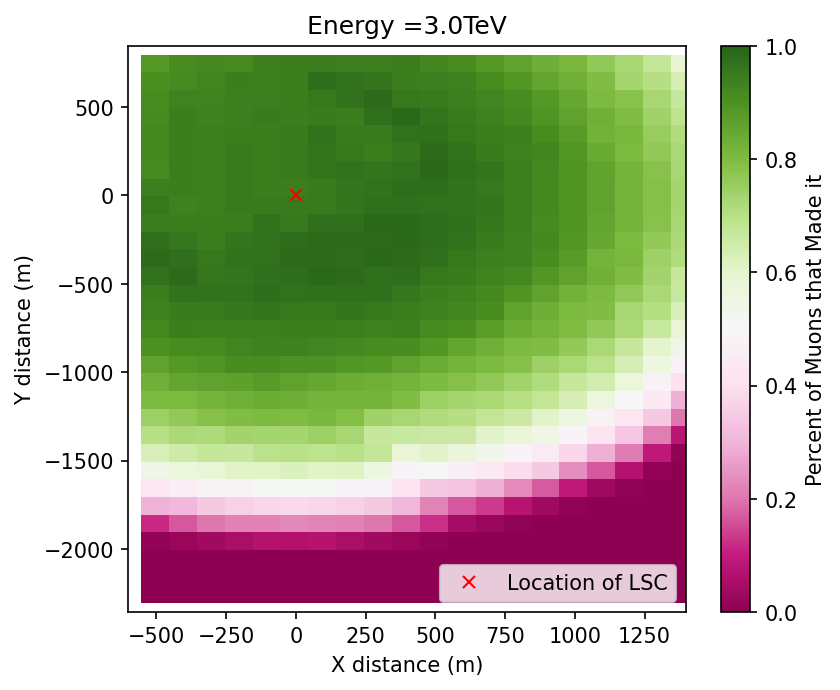

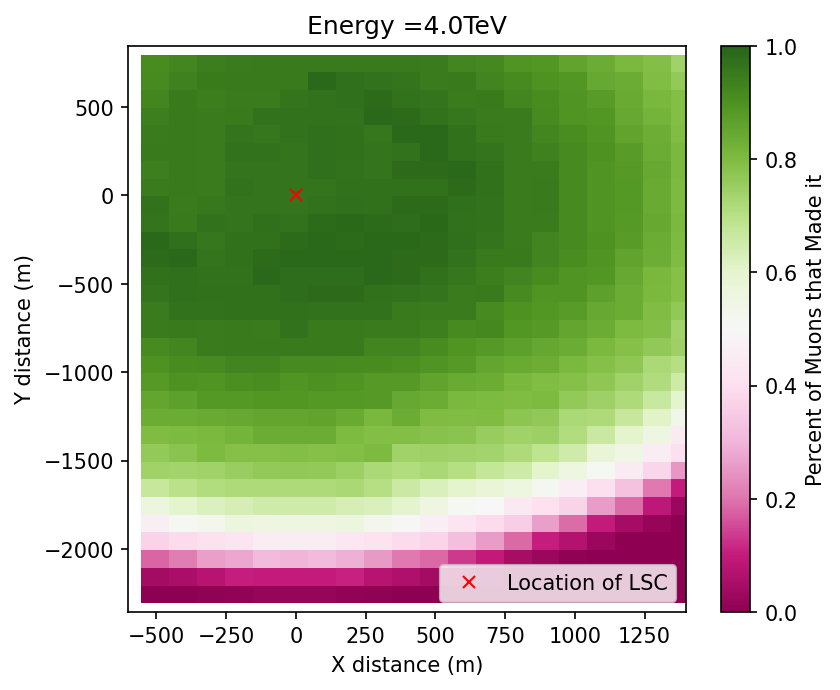

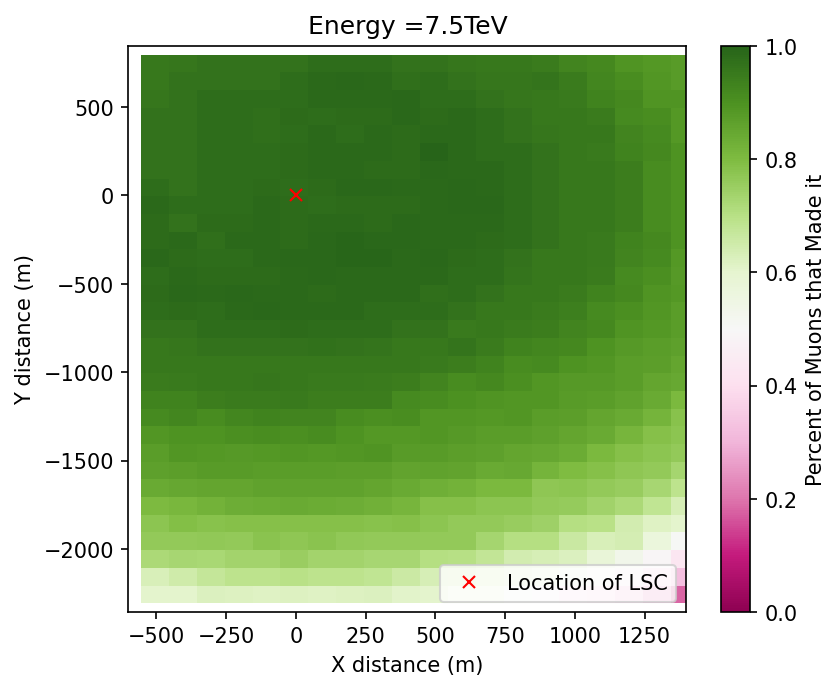

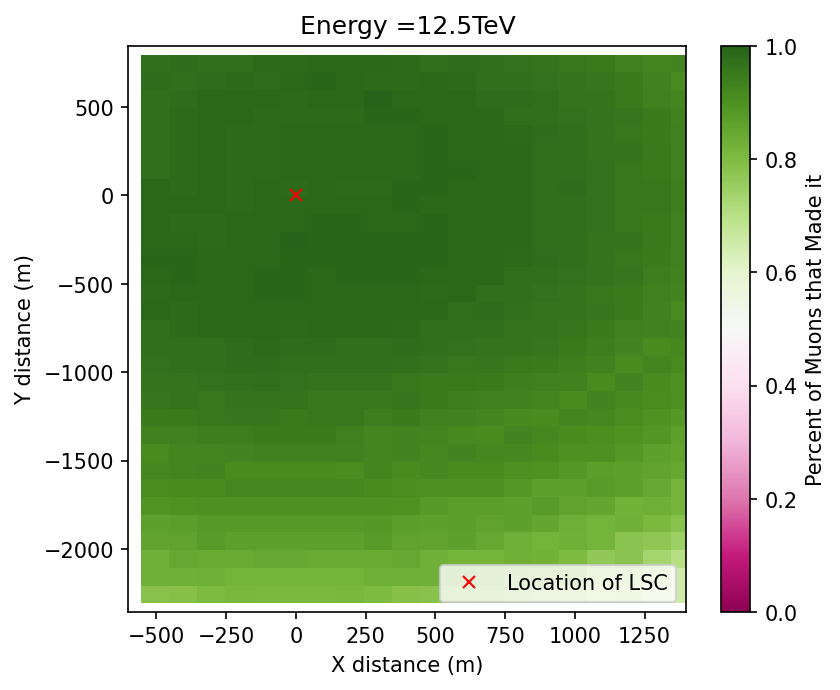

In [441]:
#proposal plots as ran
spacing=200
NumToRun=1000
Xmin=-500-spacing/2
Xmax=1500-spacing/2
Ymin=-2255-spacing/2
Ymax=745+spacing/2
for LOC in range(0,len(energies)):
    r=0
    Xs=[]
    Ys=[]
    Percs=[]

    NRG=energies[LOC]*GeV

    for X in kX:
        for Y in lY:
            percsum=0
            multi=0
            if len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)])==0:
                Xs.append(X)
                print("missing",X,Y)
                Percs.append(0) #need to rerun anything missing
                Ys.append(Y)
                continue
            if len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].FinalMuons.iloc[LOC]) <=0:
                perc=0
            else:
                perc=len(musDatamtn[(musDatamtn.X==X)&(musDatamtn.Y==Y)].FinalMuons.iloc[LOC])/NumToRun
            Xs.append(X)
            Percs.append(perc)
            Ys.append(Y)
            
    intepercs = np.array(Percs)
    intepercs=intepercs.reshape(len(np.unique(Xs)), len(np.unique(Ys)))

    cmap = plt.get_cmap('PiYG')
    # Plot the height map
    plt.figure(figsize=(6,5),dpi=150)
    plt.pcolormesh(np.unique(Xs),np.unique(Ys),np.transpose(intepercs),cmap=cmap,shading='auto')

    plt.colorbar(label='Percent of Muons that Made it')
    plt.clim(0,1)

    plt.ylim(Ymin,Ymax)
    plt.xlim(Xmin,Xmax)
    plt.xlabel("X distance (m)")
    plt.ylabel("Y distance (m)")
    plt.title("Energy ="+str(energies[LOC]*GeV/10**6)+"TeV")
    plt.plot([0],[0],'x',label='Location of LSC',color='red')
    plt.legend(loc='lower right')
    
    #plt.savefig("/Users/rogerslc/PROPOSAL/PROPOSAL/SimulatedPercents"+str(energies[LOC]*GeV/10**6)+"TeV.png",dpi=250,bbox_inches='tight')

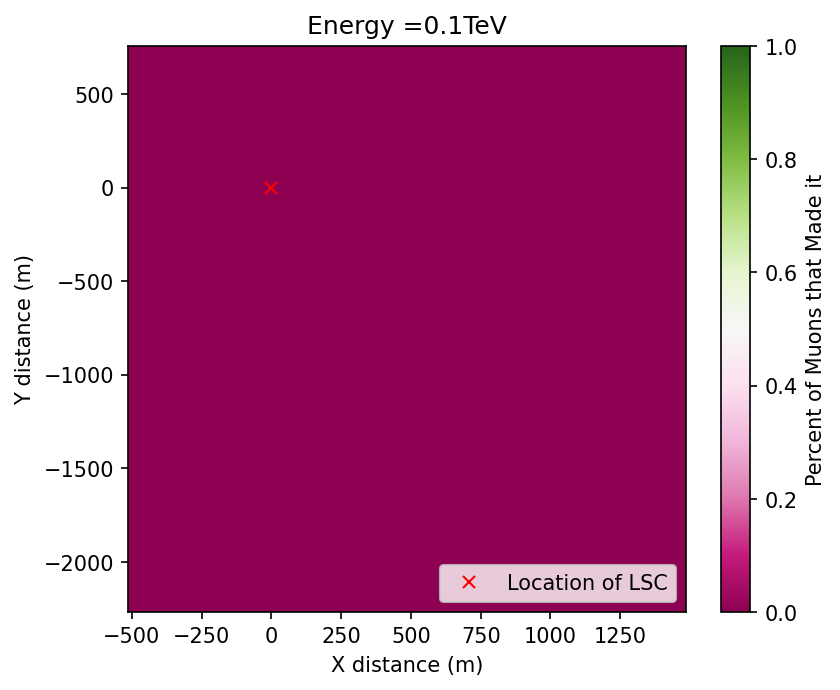

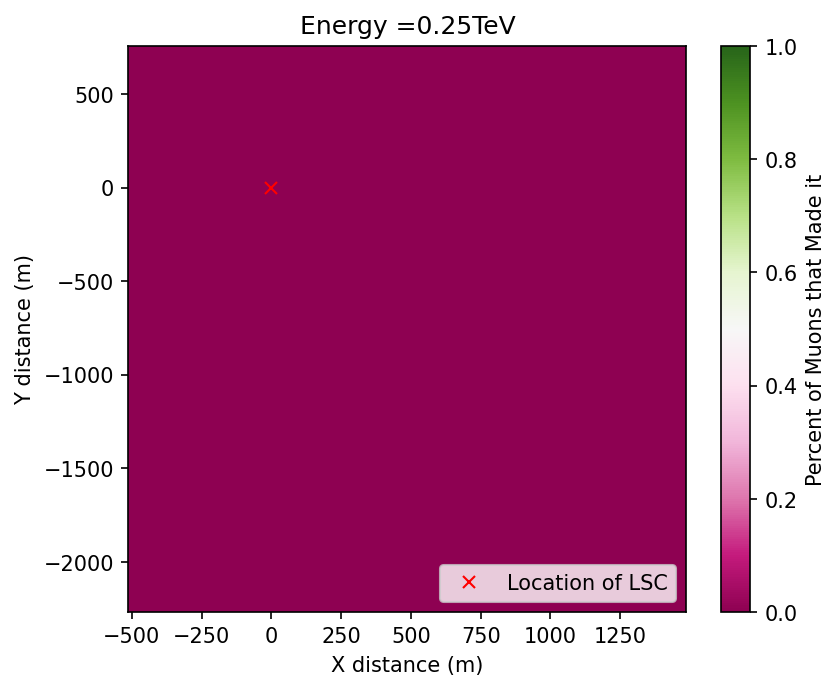

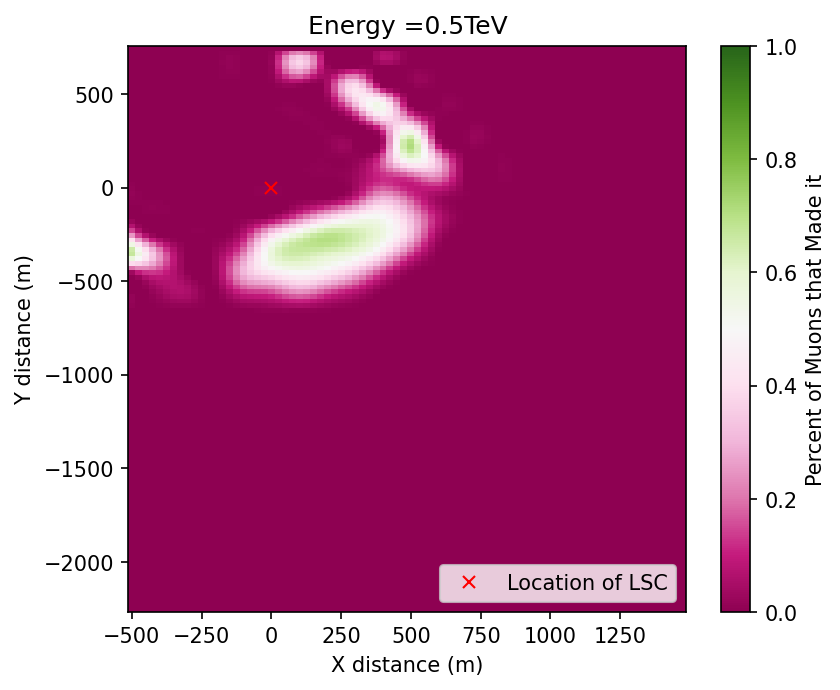

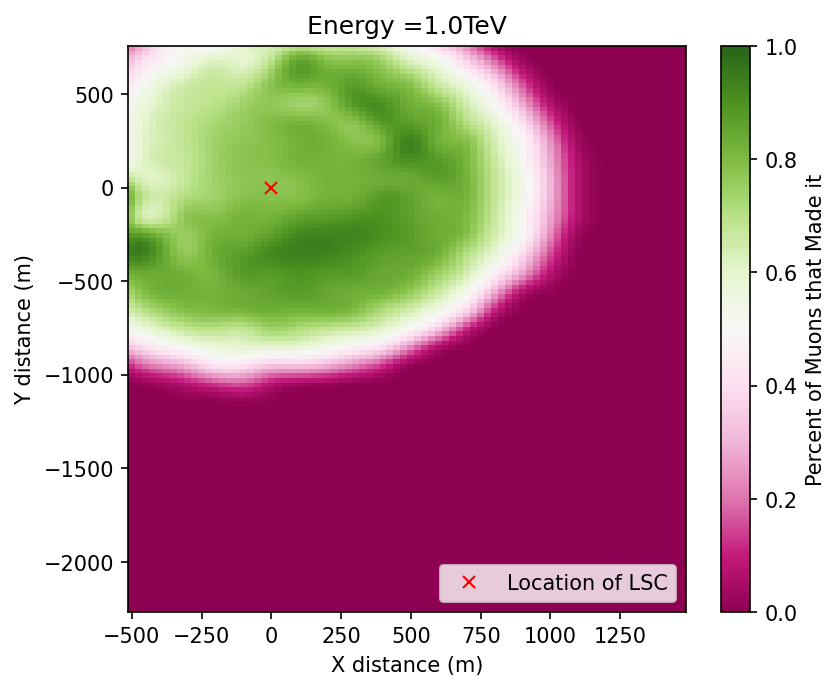

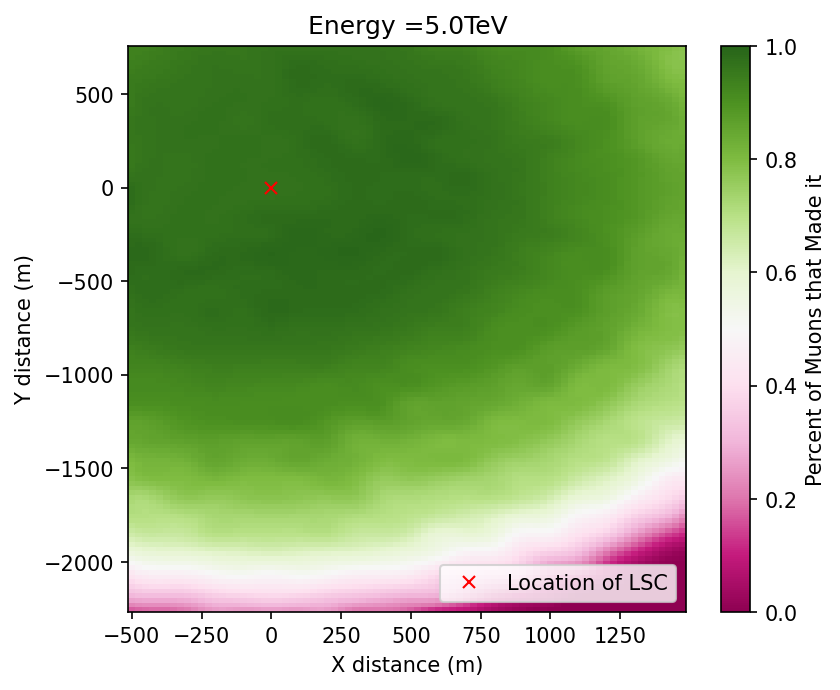

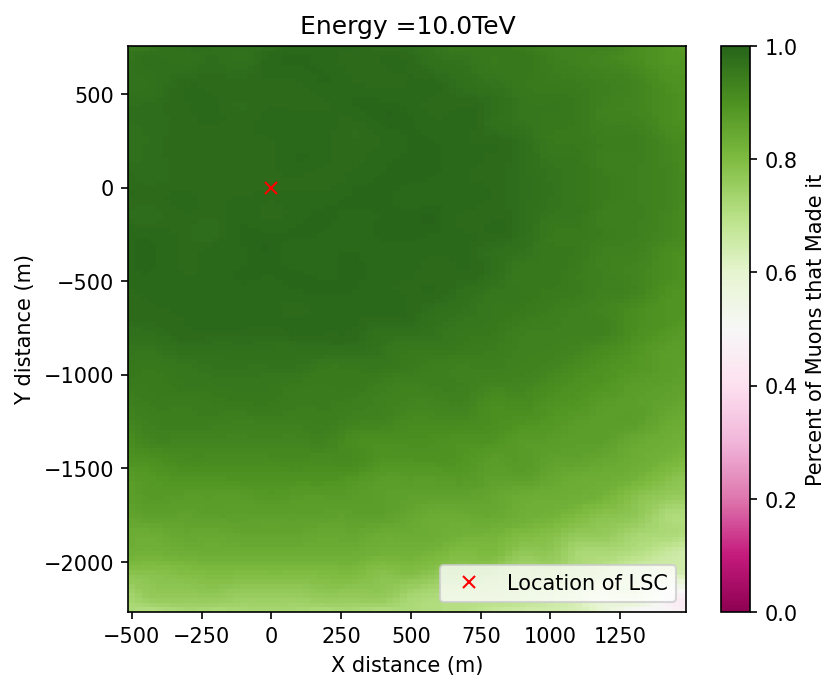

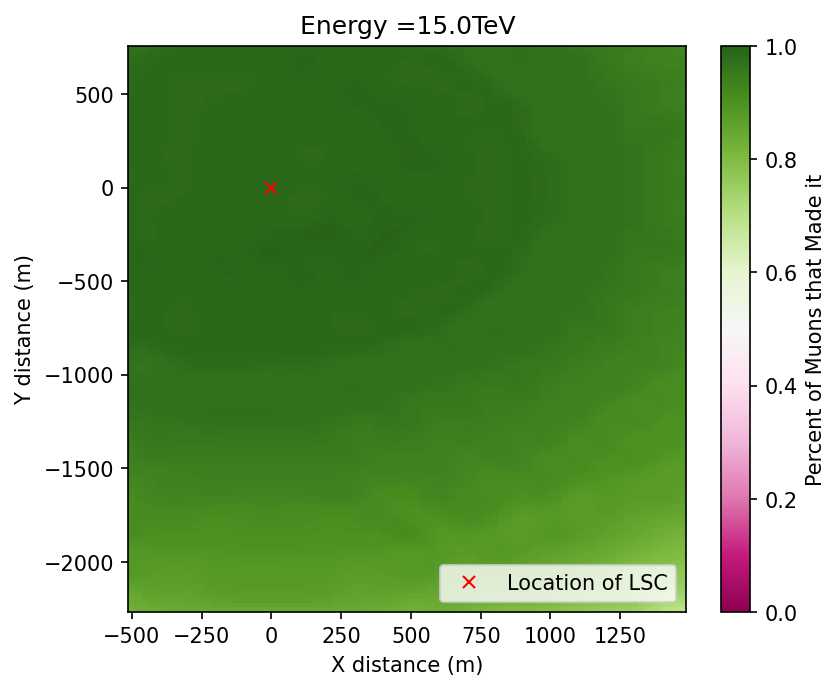

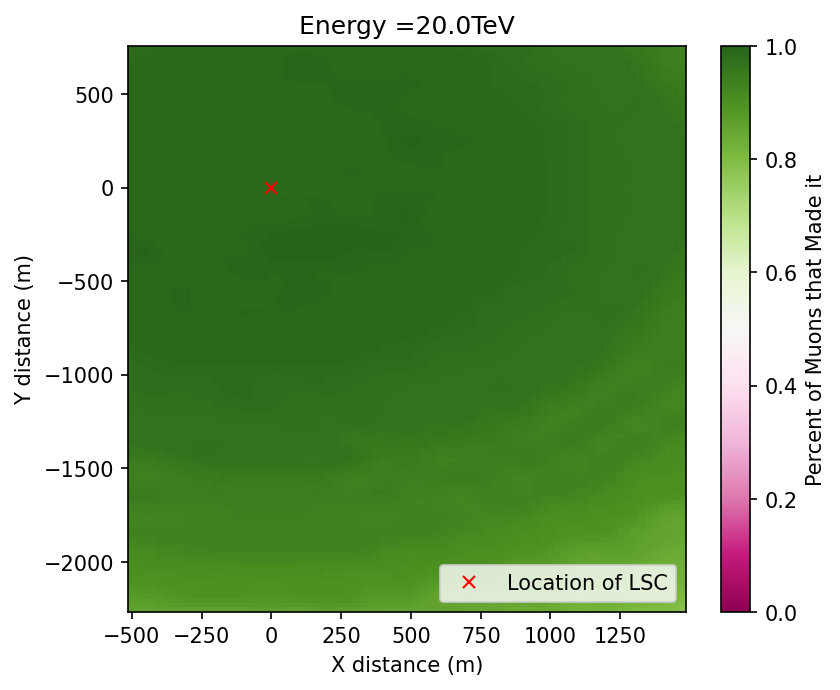

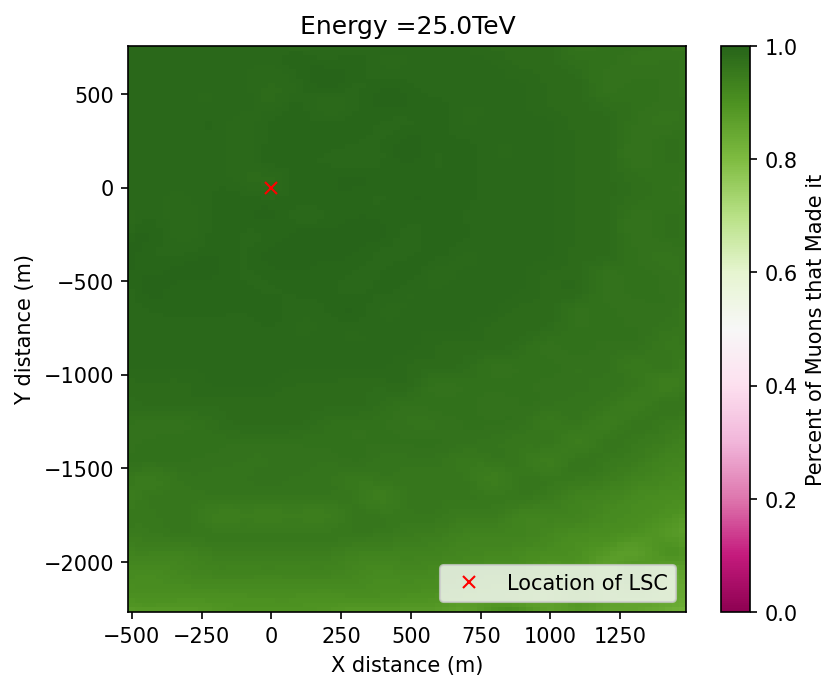

In [248]:

#interpolated plots. Choose a binning
'''spacing=25
NumToRun=1000
Xmin=-500-spacing/2
Xmax=1500-spacing/2
Ymin=-2255-spacing/2
Ymax=745+spacing/2
for LOC in range(0,len(energies)):
    r=0
    Xs=[]
    Ys=[]
    Percs=[]

    NRG=energies[LOC]*GeV

    with open('/Users/rogerslc/PROPOSAL/PROPOSAL/Proposal_Muons_interpolator'+str(NRG)+'TeV.pkl', 'rb') as f:
        PercentMuons = pickle.load(f)
        

    intexs=[]
    inteys=[]
    intepercs=[]
    for X in range(-500,1500,spacing):
        for Y in range(-2255,755,spacing):
            intexs.append(X)
            inteys.append(Y)
            intepercs.append(PercentMuons(X,Y)[0][0])


    intepercs = np.array(intepercs)
    intepercs=intepercs.reshape(len(np.unique(intexs)), len(np.unique(inteys)))

    cmap = plt.get_cmap('PiYG')
    # Plot the height map
    plt.figure(figsize=(6,5),dpi=150)
    plt.pcolormesh(np.unique(intexs),np.unique(inteys),np.transpose(intepercs),cmap=cmap,shading='auto')

    plt.colorbar(label='Percent of Muons that Made it')
    plt.clim(0,1)
    #CS=plt.contour(xx,yy,zz,colors='black')
    #plt.clabel(CS, inline=1, fontsize=10,fmt='%1.0f')

    plt.ylim(Ymin,Ymax)
    plt.xlim(Xmin,Xmax)
    plt.xlabel("X distance (m)")
    plt.ylabel("Y distance (m)")
    plt.title("Energy ="+str(energies[LOC]*GeV/10**6)+"TeV")
    plt.plot([0],[0],'x',label='Location of LSC',color='red')
    plt.legend(loc='lower right')
    
    #plt.savefig("/Users/rogerslc/PROPOSAL/PROPOSAL/InterpPercents"+str(energies[LOC]*GeV/10**6)+"TeV.png",dpi=250,bbox_inches='tight')'''

In [490]:
df[df.perc>0]

,phi,theta,perc
17,-2.67,1.13,0.872714
57,-2.58,0.74,0.958500
100,-2.25,0.46,0.956833
180,-2.16,1.36,0.904000
227,-2.06,1.34,0.919500
...,...,...,...
4080,2.07,1.05,0.879000
4128,2.17,1.03,0.842000
4166,2.27,0.42,0.942667
4219,2.60,0.58,0.924333
